# Imports

In [1]:
import torch
import random
import numpy as np
import tensorflow as tf
import os
from PIL import Image
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Read dataset

In [3]:
dataset_path = 'Dataset/images'

In [4]:
def load_images(path):
  images = []
  for image in os.listdir(path):
      img_path = os.path.join(path, image)

      img = Image.open(img_path)

      images.append(img)

  return images

In [5]:
images= load_images(dataset_path)

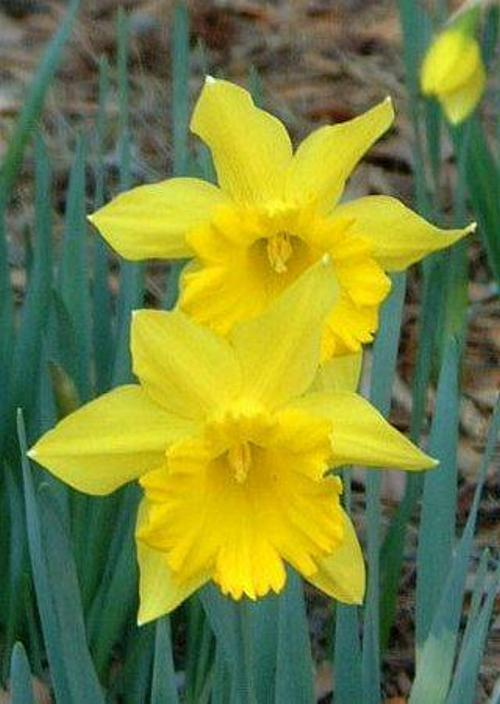

In [6]:
images[2]

## Cleaning

In [7]:
def fix_images(images):
  array_img = []
  for img in images:
    new_size = (150, 150)

    resized_img = img.resize(new_size)
    rgb_img = resized_img.convert("RGB")
    array_img.append(np.array(rgb_img))

  return array_img

In [8]:
fixed_images = fix_images(images)

In [9]:
fixed_images[0].shape

(150, 150, 3)

In [10]:
labels = []
for i in range(17):
    labels.extend([i] * 80)

# Show Histogram for Data

In [11]:
def create_histogram(data):

  value_counts = {}
  for value in data:
    value_counts[value] = value_counts.get(value, 0) + 1

  values = list(value_counts.keys())
  counts = list(value_counts.values())

  plt.bar(range(len(values)), counts)

  plt.xticks(range(len(values)), values)

  plt.xlabel("Value")
  plt.ylabel("Frequency")
  plt.title("Histogram")
  plt.show()

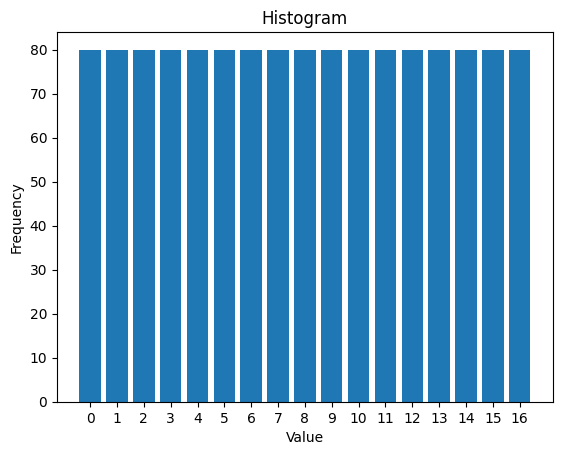

In [12]:
create_histogram(labels)

# Training

In [13]:
SEED = 42

random.seed(SEED)
random.shuffle(fixed_images)
random.seed(SEED)
random.shuffle(labels)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [14]:
train_size = int(0.8 * len(fixed_images))
val_size = int(0.1 * len(fixed_images))
test_size = len(fixed_images) - train_size - val_size

# Split the lists
train_images, val_images, test_images = fixed_images[:train_size], fixed_images[train_size:train_size+val_size], fixed_images[train_size+val_size:]
train_labels, val_labels, test_labels = labels[:train_size], labels[train_size:train_size+val_size], labels[train_size+val_size:]


In [15]:
len(train_images), len(train_labels), len(test_images), len(test_labels)

(1088, 1088, 136, 136)

In [16]:
train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)
train_images = train_images.reshape(-1, 150, 150, 3)
val_images = val_images.reshape(-1, 150, 150, 3)
test_images = test_images.reshape(-1, 150, 150, 3)

In [17]:
base_model = keras.applications.EfficientNetV2S(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

In [18]:
for layer in base_model.layers:
    layer.trainable = False

In [19]:
model_1 = Sequential()

# Feature Extraction Stage
model_1.add(base_model)

# Classification Stage
# Construct the head of the model that will be placed on top of the base model
model_1.add(Flatten())
model_1.add(Dense(units=64, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(units=17, activation='softmax'))

In [20]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-s (Functional)   │ (None, 5, 5, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,048,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 17)             │         1,105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,380,529 (85.37 MB)

 Trainable params: 2,049,169 (7.82 MB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [21]:
train_labels = to_categorical(train_labels, num_classes=17)
val_labels = to_categorical(val_labels, num_classes=17)
test_labels = to_categorical(test_labels, num_classes=17)

In [22]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((1088, 150, 150, 3), (1088, 17), (136, 150, 150, 3), (136, 17))

In [23]:
train_images = keras.applications.efficientnet_v2.preprocess_input(train_images)
val_images = keras.applications.efficientnet_v2.preprocess_input(val_images)
test_images = keras.applications.efficientnet_v2.preprocess_input(test_images)

In [24]:
model_1.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
batch_size = 32
epochs = 50

history = model_1.fit(
    x=train_images, 
    y=train_labels, 
    validation_data=(val_images, val_labels), 
    batch_size=batch_size, 
    epochs=epochs,
    callbacks=[
        EarlyStopping(
            monitor='val_loss', 
            mode='min', 
            verbose=1, 
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 671ms/step - accuracy: 0.1822 - loss: 2.8562 - val_accuracy: 0.6029 - val_loss: 1.5239
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 540ms/step - accuracy: 0.4364 - loss: 1.6177 - val_accuracy: 0.7941 - val_loss: 1.0209
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 532ms/step - accuracy: 0.5209 - loss: 1.3496 - val_accuracy: 0.7868 - val_loss: 0.6784
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 510ms/step - accuracy: 0.5997 - loss: 1.1902 - val_accuracy: 0.8162 - val_loss: 0.6231
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 514ms/step - accuracy: 0.6346 - loss: 1.0277 - val_accuracy: 0.8897 - val_loss: 0.4566
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 502ms/step - accuracy: 0.7045 - loss: 0.8295 - val_accuracy: 0.8750 - val_loss: 0.4644
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 499ms/step - accuracy: 0.7091 - loss: 0.8227 - val_accuracy: 0.8529 - val_loss: 0.5250
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 497ms/step - accuracy: 0.7478 - loss: 0.7440 - val_accu

In [26]:
test_loss, test_acc = model_1.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 369ms/step - accuracy: 0.8429 - loss: 0.5129
Test Loss: 0.4542922377586365
Test Accuracy: 85.29%


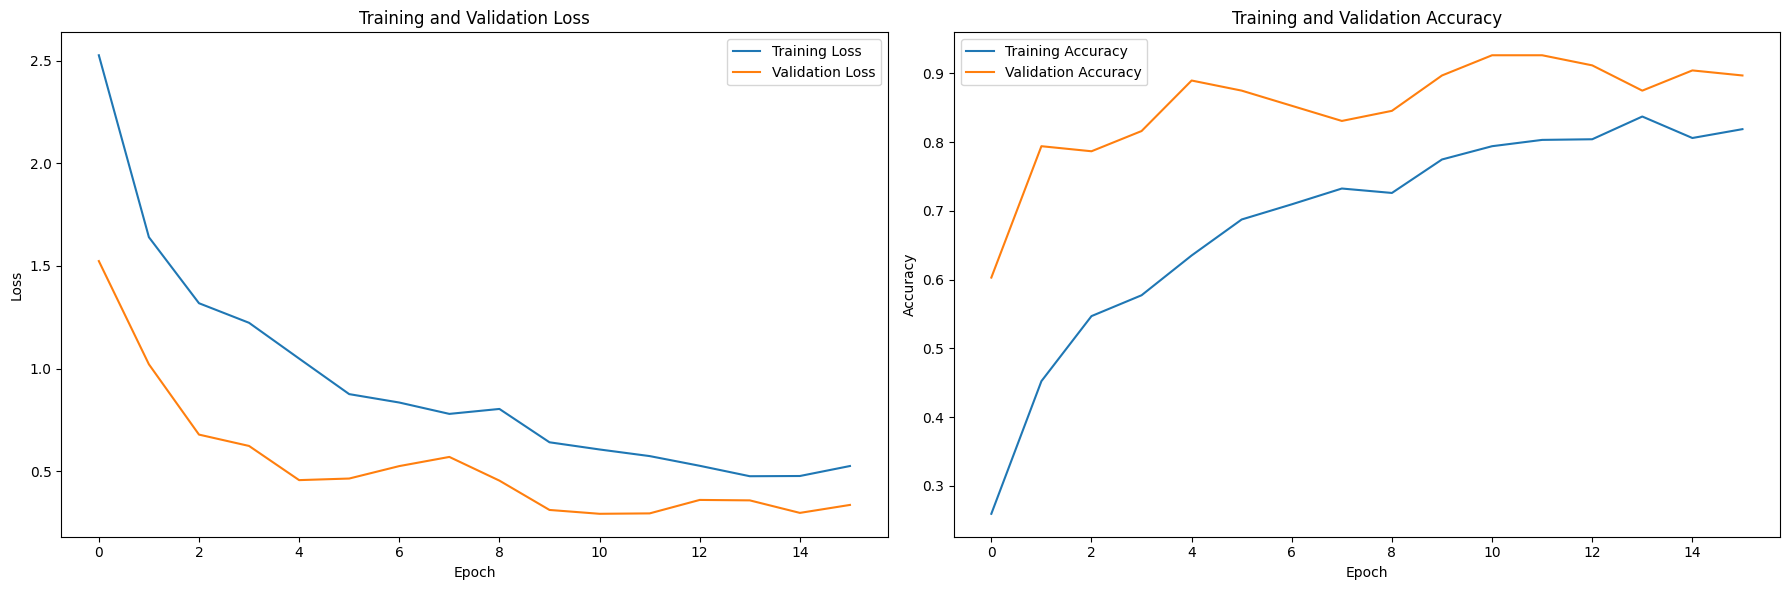

In [27]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training, validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
# Predictions on the test set
test_predictions = model_1.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=-1)

# Convert one-hot encoded labels back to integers
test_true_classes = np.argmax(test_labels, axis=-1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step  


In [29]:
# Classification Report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(y_true=test_true_classes, y_pred=test_predictions_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       1.00      0.88      0.93         8
           2       0.75      0.75      0.75        12
           3       0.71      0.83      0.77         6
           4       0.60      1.00      0.75         6
           5       1.00      0.83      0.91        12
           6       1.00      0.89      0.94         9
           7       0.67      0.50      0.57         4
           8       0.86      1.00      0.92         6
           9       1.00      1.00      1.00        11
          10       0.78      1.00      0.88         7
          11       1.00      0.83      0.91         6
          12       1.00      1.00      1.00         3
          13       1.00      0.57      0.73         7
          14       0.64      0.88      0.74         8
          15       1.00      0.89      0.94         9
          16       1.00      0.81      0.90        16

   

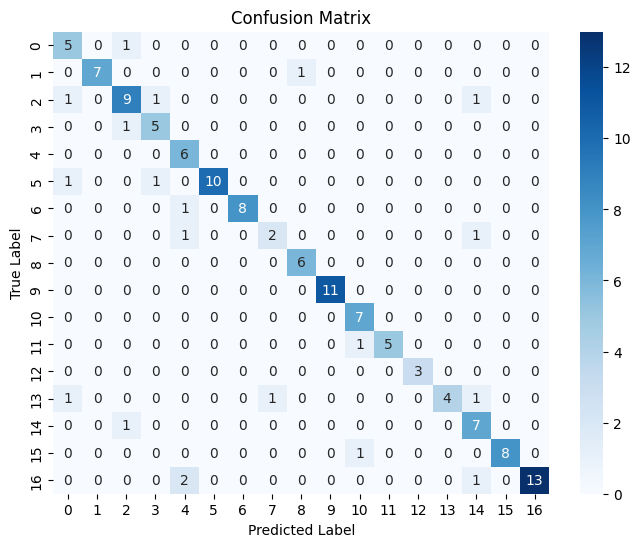

In [30]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_true_classes, test_predictions_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(17), yticklabels=range(17))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Fine-tune the whole network

In [31]:
fine_tune_model = keras.applications.EfficientNetV2S(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

In [32]:
for layer in fine_tune_model.layers:
    layer.trainable = True

In [33]:
model_2 = Sequential()

# Feature Extraction Stage
model_2.add(fine_tune_model)

# Classification Stage
# Construct the head of the model that will be placed on top of the base model
model_2.add(Flatten())
model_2.add(Dense(units=64, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(units=17, activation='softmax'))

In [34]:
model_2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
batch_size = 32
epochs = 50

history = model_2.fit(
    x=train_images, 
    y=train_labels, 
    validation_data = (val_images, val_labels), 
    batch_size=batch_size, 
    epochs=epochs,
    callbacks=[
        EarlyStopping(
            monitor='val_loss', 
            mode='min', 
            verbose=1, 
            patience=5,
            restore_best_weights=True
            )
        ]
    )

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.2318 - loss: 2.5298 - val_accuracy: 0.8088 - val_loss: 0.5773
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6674 - loss: 1.0180 - val_accuracy: 0.8162 - val_loss: 0.8980
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7129 - loss: 1.0014 - val_accuracy: 0.8309 - val_loss: 0.6622
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.7852 - loss: 0.8522 - val_accuracy: 0.8456 - val_loss: 0.6522
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.8184 - loss: 0.5996 - val_accuracy: 0.7647 - val_loss: 1.2802
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.8037 - loss: 0.8251 - val_accuracy: 0.8971 - val_loss: 0.4042
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.8331 - loss: 0.5761 - val_accuracy: 0.7941 - val_loss: 1.1832
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.8380 - loss: 0.5351 - val_accuracy: 0.8750 - val_loss

In [36]:
test_loss, test_acc = model_2.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 404ms/step - accuracy: 0.9022 - loss: 0.4627
Test Loss: 0.45208555459976196
Test Accuracy: 90.44%


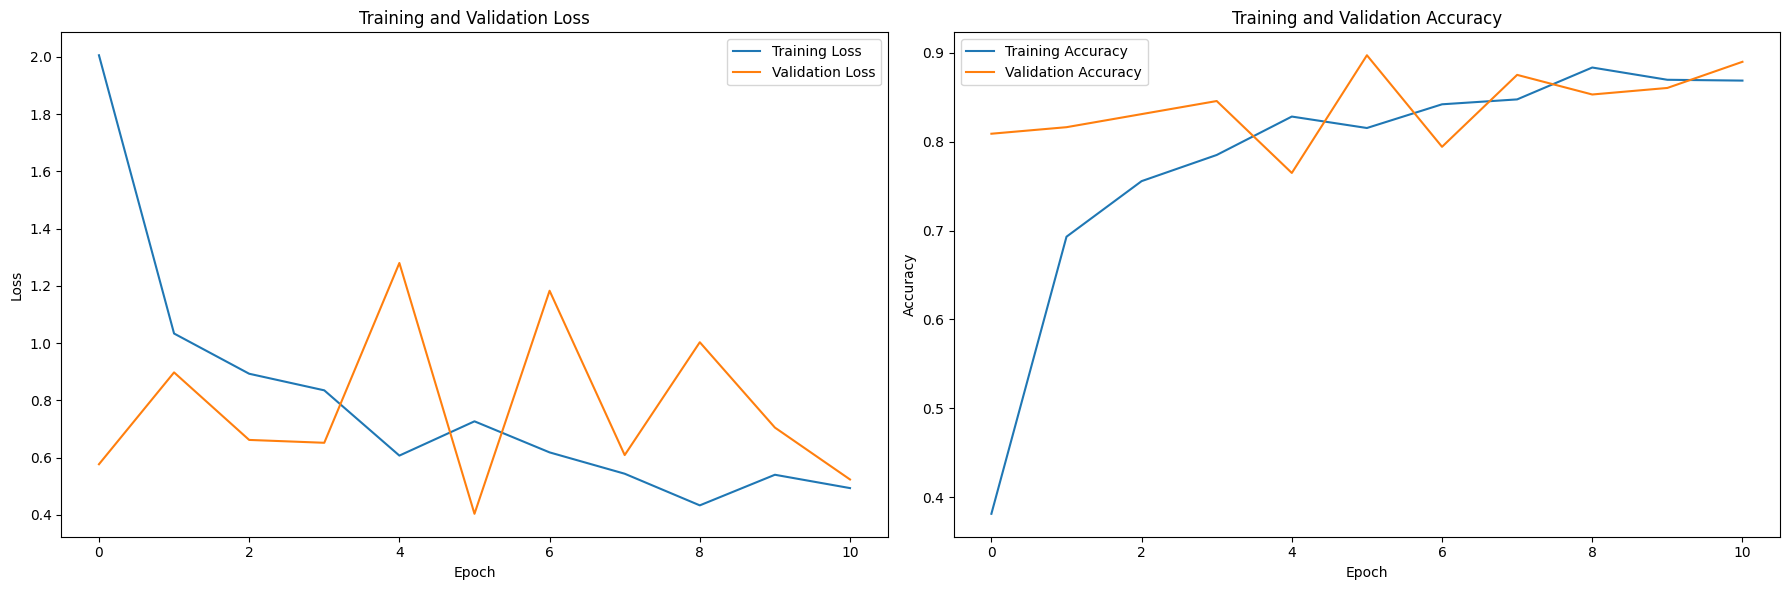

In [37]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training, validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
# Predictions on the test set
test_predictions = model_2.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=-1)

# Convert one-hot encoded labels back to integers
test_true_classes = np.argmax(test_labels, axis=-1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step 


In [39]:
# Classification Report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(y_true=test_true_classes, y_pred=test_predictions_classes))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.78      0.88      0.82         8
           2       1.00      0.92      0.96        12
           3       0.83      0.83      0.83         6
           4       0.75      1.00      0.86         6
           5       0.92      1.00      0.96        12
           6       1.00      1.00      1.00         9
           7       0.57      1.00      0.73         4
           8       0.83      0.83      0.83         6
           9       1.00      0.91      0.95        11
          10       0.88      1.00      0.93         7
          11       1.00      0.83      0.91         6
          12       0.67      0.67      0.67         3
          13       1.00      0.86      0.92         7
          14       1.00      0.75      0.86         8
          15       0.89      0.89      0.89         9
          16       1.00      0.88      0.93        16

   

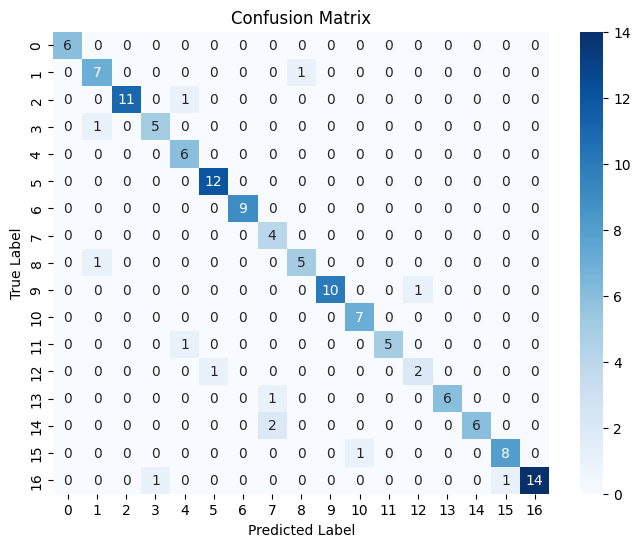

In [40]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_true_classes, test_predictions_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(17), yticklabels=range(17))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()